# Doing a single pulsar analysis with non-linear timing
This tutorial is to guide you through setting up and sampling a single pulsar with non-linear timing with `enterprise`.

In [1]:
import os
import sys
import inspect
import time
import warnings
import pickle
import corner
import numpy as np

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [3]:
import enterprise
from enterprise.pulsar import Pulsar

import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore


from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [4]:
import enterprise_extensions as e_e
from enterprise_extensions import sampler
from enterprise_extensions import models

In [5]:
datadir = ('/').join(e_e.__path__[0].split('/')[:-1])
parfile = f'{datadir}/tests/data/J1640+2224_ng9yr_dmx_DE421.par'
timfile = f'{datadir}/tests/data/J1640+2224_ng9yr_dmx_DE421.tim'

## Load the Pulsar
Make sure the ephemeris is the same as in the parfile and you have to retain the t2pulsar object. If you want to use `PINT` that is also cool, just change the final two kwargs to `drop_pintpsr=False, timing_package="pint"`

In [6]:
psr = Pulsar(parfile,timfile,ephem='DE421',clk=None,drop_t2pulsar=False,timing_package="tempo2",)

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
[tempo2Util.C:396] Warning: [PAR1] Have not set a position epoch. The period epoch will be used instead. J1640+2224_ng9yr_dmx_DE421.par
[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. J1640+2224_ng9yr_dmx_DE421.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


## Make lists for non-linear, linear, or fixed parameters
`Offset` is unique to `libstempo` and is always linearly varied. All other parameters are fair game. We have found pretty conclusive evidence that in most cases you can linearly vary all the DMX, JUMP, and FD parameters, so this example will do that. We don't necessarily reccommend fixing any parameters unless you are really sure that is what you want to do. Finally, if the pulsar is in a binary, we reccommend sampling the orbital inclination in cosine instead of sine since a collection of randomly-oriented binary systems exhibits a uniform distribution in cos(i).

* It is necessary to correct the units on `PBDOT` and `XDOT` if you use a `libstempo` pulsar as the errors on the value is assumed to be in different units than `PINT` or `TEMPO2`. To do so, you construct a new prior and add it into `tm_param_dict`, a dictionary to handle any exceptions to the assumed prior of `[-scale_val*parfile_sigma,scale_val*parfile_sigma]`. If you are are using `Uniform` as the prior type (explained where later), you only need to assign the `prior_lower_bound` and `prior_upper_bound`, but for the `BoundedNormal` prior, you need those and `prior_mu`, the mean of the prior distribution, and `prior_sigma` the distribution's variance.
* If you want to use other distributions, you would add the parameter to `tm_param_dict` and specify the distribution function. We have an example one that uses a prior on the parallax (`PX`) based on the implied dispersion measure (DM) distance from the NE2001 model (Cordes & Lazio, 2002).

In [7]:
nltm_params = []
ltm_params = []
tm_param_dict = {}
for par in psr.fitpars:
    if par == "Offset":
        ltm_params.append(par)
    elif "DMX" in par:
        ltm_params.append(par)
    elif "JUMP" in par:
        ltm_params.append(par)
    elif "FD" in par:
        ltm_params.append(par)
    elif par == "SINI":
        nltm_params.append("COSI")
    else:
        nltm_params.append(par)

    if par in ["PBDOT", "XDOT"] and hasattr(psr, "t2pulsar"):
        # Get the parfile value and error
        par_val = np.double(psr.t2pulsar.vals()[psr.t2pulsar.pars().index(par)])
        par_sigma = np.double(psr.t2pulsar.errs()[psr.t2pulsar.pars().index(par)])
        # If the units are actually at the wrong scale set a prior by hand
        if np.log10(par_sigma) > -10.0:
            print(f"USING PHYSICAL {par}. Val: ", par_val, "Err: ", par_sigma * 1e-12)
            lower = par_val - 50 * par_sigma * 1e-12
            upper = par_val + 50 * par_sigma * 1e-12
            tm_param_dict[par] = {
                "prior_mu": par_val,
                "prior_sigma": par_sigma * 1e-12,
                "prior_lower_bound": lower,
                "prior_upper_bound": upper,
            }

    if par == "PX":
        # The way of extracting parfile values is different between a `t2pulsar` and a `pintpsr`
        if hasattr(psr, "t2pulsar"):
            # `t2pulsar` version
            tm_param_dict[par] = {
                "prior_mu": np.double(
                    psr.t2pulsar.vals()[psr.t2pulsar.pars().index(par)]
                ),
                "prior_sigma": np.double(
                    psr.t2pulsar.errs()[psr.t2pulsar.pars().index(par)]
                ),
                "prior_type": "dm_dist_px_prior",
            }
        elif hasattr(psr, "model"):
            # `pintpsr` version
            tm_param_dict[par] = {
                "prior_mu": np.double(getattr(psr.model, par).value),
                "prior_sigma": np.double(getattr(psr.model, par).uncertainty_value),
                "prior_type": "dm_dist_px_prior",
            }

USING PHYSICAL XDOT. Val:  1.4528e-14 Err:  9.78e-16


In [8]:
print("Non-linearly varied parameters:",nltm_params,"\n")
print("Linearly varied parameters:",ltm_params,"\n")
print("Other unique parameters and priors:",tm_param_dict)

Non-linearly varied parameters: ['ELONG', 'ELAT', 'F0', 'F1', 'PMELONG', 'PMELAT', 'PX', 'COSI', 'PB', 'T0', 'A1', 'OM', 'ECC', 'XDOT', 'OMDOT', 'M2'] 

Linearly varied parameters: ['Offset', 'FD1', 'FD2', 'DMX_0001', 'DMX_0002', 'DMX_0003', 'DMX_0004', 'DMX_0005', 'DMX_0006', 'DMX_0007', 'DMX_0008', 'DMX_0009', 'DMX_0010', 'DMX_0011', 'DMX_0012', 'DMX_0013', 'DMX_0014', 'DMX_0015', 'DMX_0016', 'DMX_0017', 'DMX_0018', 'DMX_0019', 'DMX_0020', 'DMX_0021', 'DMX_0022', 'DMX_0023', 'DMX_0024', 'DMX_0025', 'DMX_0026', 'DMX_0027', 'DMX_0028', 'DMX_0029', 'DMX_0030', 'DMX_0031', 'DMX_0032', 'DMX_0033', 'DMX_0034', 'DMX_0035', 'DMX_0036', 'DMX_0037', 'DMX_0038', 'DMX_0039', 'DMX_0040', 'DMX_0041', 'DMX_0042', 'DMX_0043', 'DMX_0044', 'DMX_0045', 'DMX_0046', 'DMX_0047', 'DMX_0048', 'DMX_0049', 'DMX_0050', 'DMX_0051', 'DMX_0052', 'DMX_0053', 'DMX_0054', 'DMX_0055', 'DMX_0056', 'DMX_0057', 'DMX_0058', 'DMX_0059', 'DMX_0060', 'DMX_0061', 'DMX_0062', 'DMX_0063', 'DMX_0064', 'DMX_0065', 'JUMP1'] 

Oth

## Setting up the "`pta`"
The pure easiest way to do this is to use the `model_singlepsr_noise` from the `models` package in `enterprise_extensions`.
* The non-linear timing model automatically uses a rescaled value of all timing model parameters based on the error in the parfile, this allows for more stable sampling of parameters with extreme precision like the pulsar frequency `F0`. The exceptions to this are the parameters in `tm_param_dict` and parameters that end up outside physical bounds (e.g. `COSI` > 1, `PX` < 0, `M2` < 0). The latter is handled automatically, but if you don't want this rescaling, you will need to add parameters and their bounds to `tm_param_dict` as shown previously.
* `tm_prior` can be either a uniform prior between `[-normalize_prior_bound,normalize_prior_bound]` or a bounded-normal prior with mean as the parfile value and variance of the parfile error bounded between `[-normalize_prior_bound,normalize_prior_bound]`.

In [9]:
pta = models.model_singlepsr_noise(psr, tm_var=True,
                                   tm_param_list = nltm_params,
                                   ltm_list = ltm_params,
                                   tm_param_dict = tm_param_dict,
                                   tm_prior="uniform",
                                   normalize_prior_bound = 50.)

COSI added to tm_params_orig for to work with tm_delay.


## Setup Sampler
Use `PTMCMCSampler` sampler to sample. We usually use `enterprise_extensions.sampler.setup_sampler` to make things easier.
* To properly setup with non-linear timing, `timing` needs to be `True`
* There is also an option to restrict the pulsar mass to less than three solar masses. This isn't necessary, but it provides another controllable factor on a parameter that has a theoretical upper-bound.

In [10]:
outdir = './chains'
psampler = sampler.setup_sampler(
        pta,
        outdir=outdir,
        resume=False,
        timing=True,
        psr=psr,
        restrict_mass=True,
    )

Adding red noise prior draws...

Adding timing model jump proposal...

Adding timing model prior draw...

Adding SCAM Jump Proposal...

Adding AM Jump Proposal...



Save the original timing model parameters (i.e. the parfile values) for plotting later

In [11]:
with open(outdir + "/orig_timing_pars.pkl", "wb") as fout:
    pickle.dump(psr.tm_params_orig, fout)

## Construct Initial Parameter Samples
We have found that to get quicker convergence and more well behaved chains, it is best to start all non-linearly varied timing model parameters at the center of their priors, which in most cases is the parfile value. We find that the parameters can still explore the space, but tend not to get stuck in bad regions of space as when all parameters are randomly selected, initially.

In [12]:
x0_list = []
for p in pta.params:
    if "timing" in p.name:
        if "DMX" in p.name:
            p_name = ("_").join(p.name.split("_")[-2:])
        else:
            p_name = p.name.split("_")[-1]
        if psr.tm_params_orig[p_name][-1] == "normalized":
            # If the parameter is in our 'normalized' space where the parfile is zero.
            x0_list.append(np.double(0.0))
        else:
            # Otherwise, we need to extract the center value from the user assigned `tm_param_dict`
            # or from the non-normalized value in `psr.tm_params_orig`
            if p_name in tm_param_dict.keys():
                x0_list.append(np.double(tm_param_dict[p_name]["prior_mu"]))
            else:
                x0_list.append(np.double(psr.tm_params_orig[p_name][0]))
    else:
        # If not a timing parameter, just use a random sample
        x0_list.append(p.sample())
x0 = np.asarray(x0_list)
x0

array([ 7.94846543e+00, -5.10607490e+00, -7.25577915e+00,  2.34616953e+00,
       -5.63694431e+00, -7.33268917e+00,  8.41039258e+00, -5.77544647e+00,
       -7.31479547e+00,  1.54295662e+00, -8.11814823e+00, -7.42067186e+00,
        6.88951382e+00, -1.25343810e+01,  0.00000000e+00,  4.58599628e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.10979000e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.68200000e-01,
        0.00000000e+00,  1.45280000e-14])

## Sample
* It should be noted that if you are using the restricted pulsar mass, the Single Component Adaptive Metropolis Jumps (SCAM) and Adaptive Metropolis Jumps don't work with out-of-the-box `PTMCMCSampler` so we had to adapt them inside `enterprise_extensions.sampler` and adjust `PTMCMCSampler` itself. The sampler will still use both the SCAM and AM jumps, but they were added in the `setup_sampler` step if `restrict_mass=True` and taken out of automatically initalizing in `PTMCMCSampler`. If you are having trouble using `restrict_mass=True` because of `NaN` or `Inf` `ValueErrors`, the issue is probably with `PTMCMCSampler` using the default SCAM and AM Jumps.
   * That being said, sometimes there will still be proposals that stray outside, or get close to outside of the restricted space. In those cases, when the sampler tries more than 500 different draws that affect the pulsar mass, a message will be printed out with the jump proposal from which it was called, how many other sample attempts it tried before giving up (Emergency iter, which the max is set to 1000 by default), and the pulsar mass with which it ended up. 
* We couldn't really get the Differential Evolution to work with the restricted mass, so that would be off the table (until we figure it out). If you aren't restricting the mass, set the `SCAMweight`, `AMweight`, and `DEweight` to whatever you want!

In [13]:
N_samples = 5000

In [14]:
start = time.time()
psampler.sample(
        x0,
        N_samples,
        SCAMweight=0,
        AMweight=0,
        DEweight=0,
    )
print("Finished in:",time.time()-start,"seconds")

Finished 80.00 percent in 147.974747 s Acceptance rate = 0.189
Run Complete
Finished in: 185.69289588928223 seconds


## Plotting
Some basic plotting using `la_forge`

In [15]:
core_anm_nltm = TimingCore(chaindir='./chains',
                           tm_pars_path='./chains/orig_timing_pars.pkl',
                           burn=0.25)

### `la_forge` trace plots

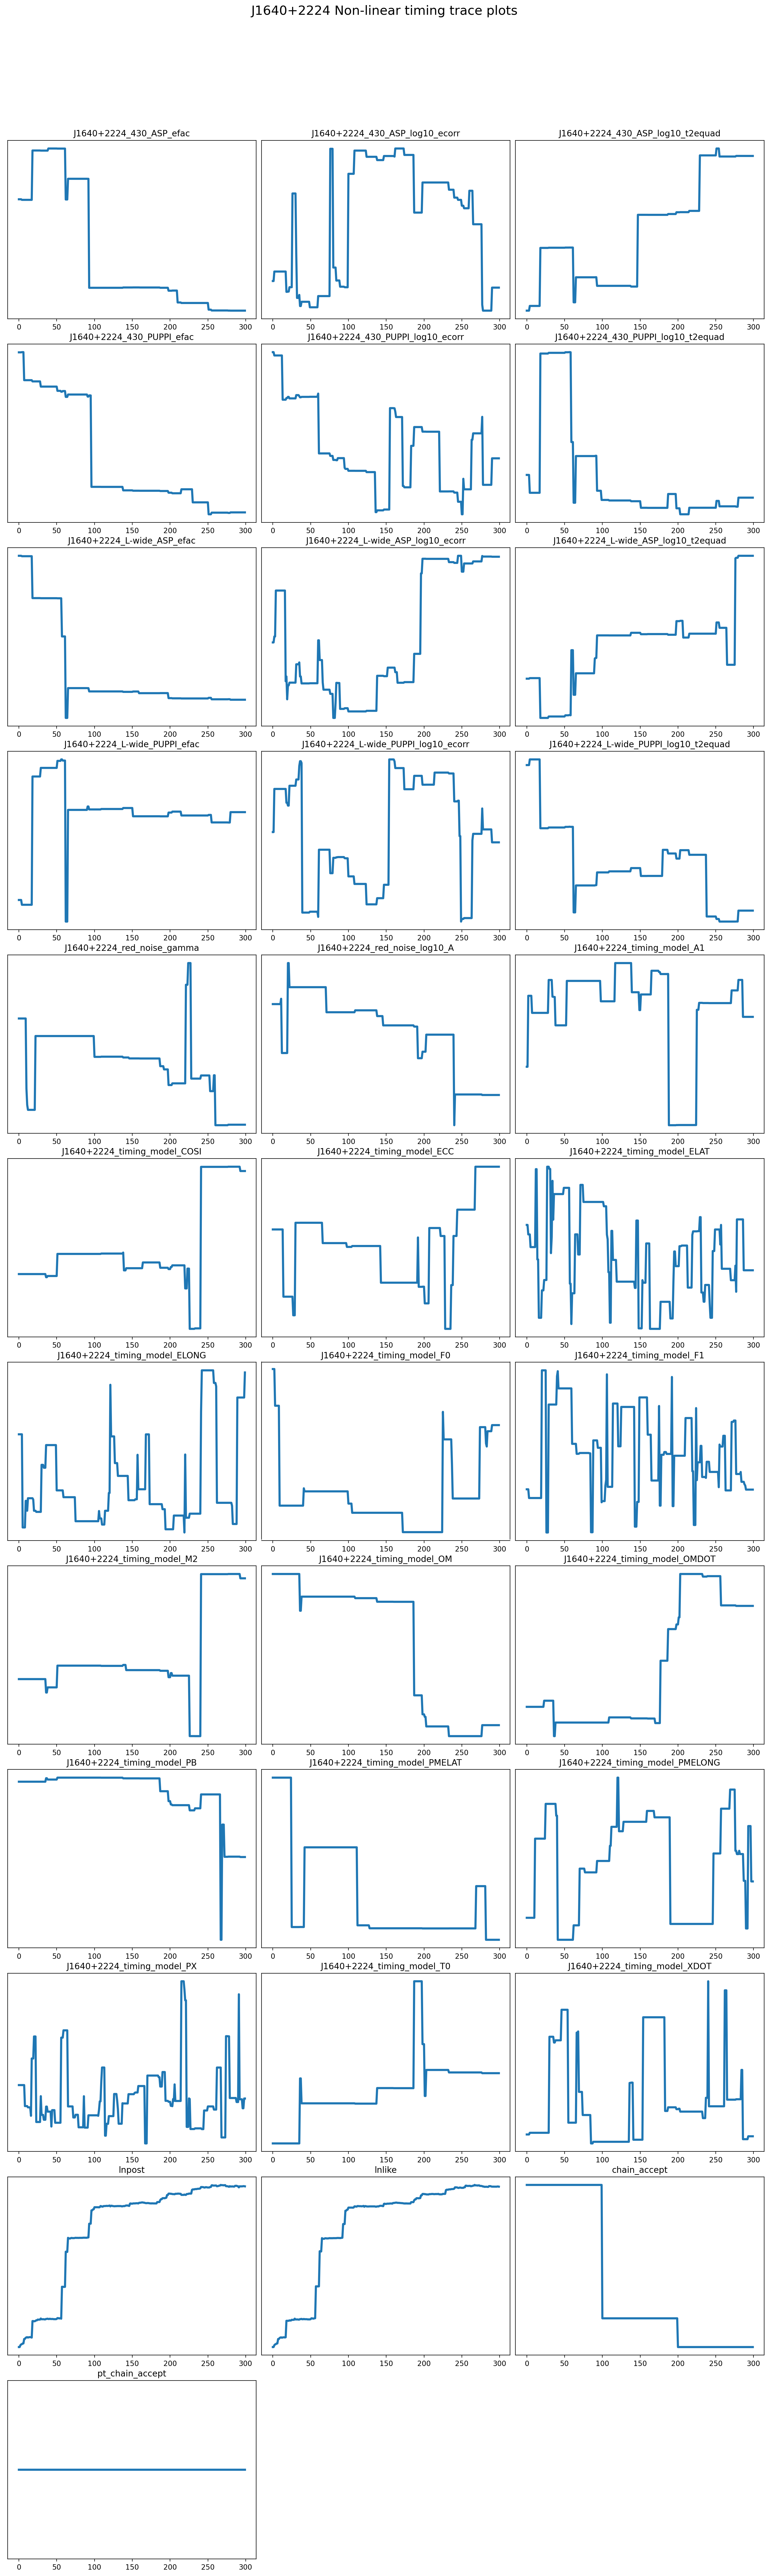

In [16]:
trace_core_kwargs = {'hist':False, 'ncols':3,'title_y':1.05,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(core_anm_nltm,
               suptitle="J1640+2224 Non-linear timing trace plots",
               **trace_core_kwargs)

### `la_forge` posterior plots
The default plots are in the normalized space if the parameter was labelled normalized in `tm_params_orig`, you can also turn it off with the flag for `real_tm_pars`

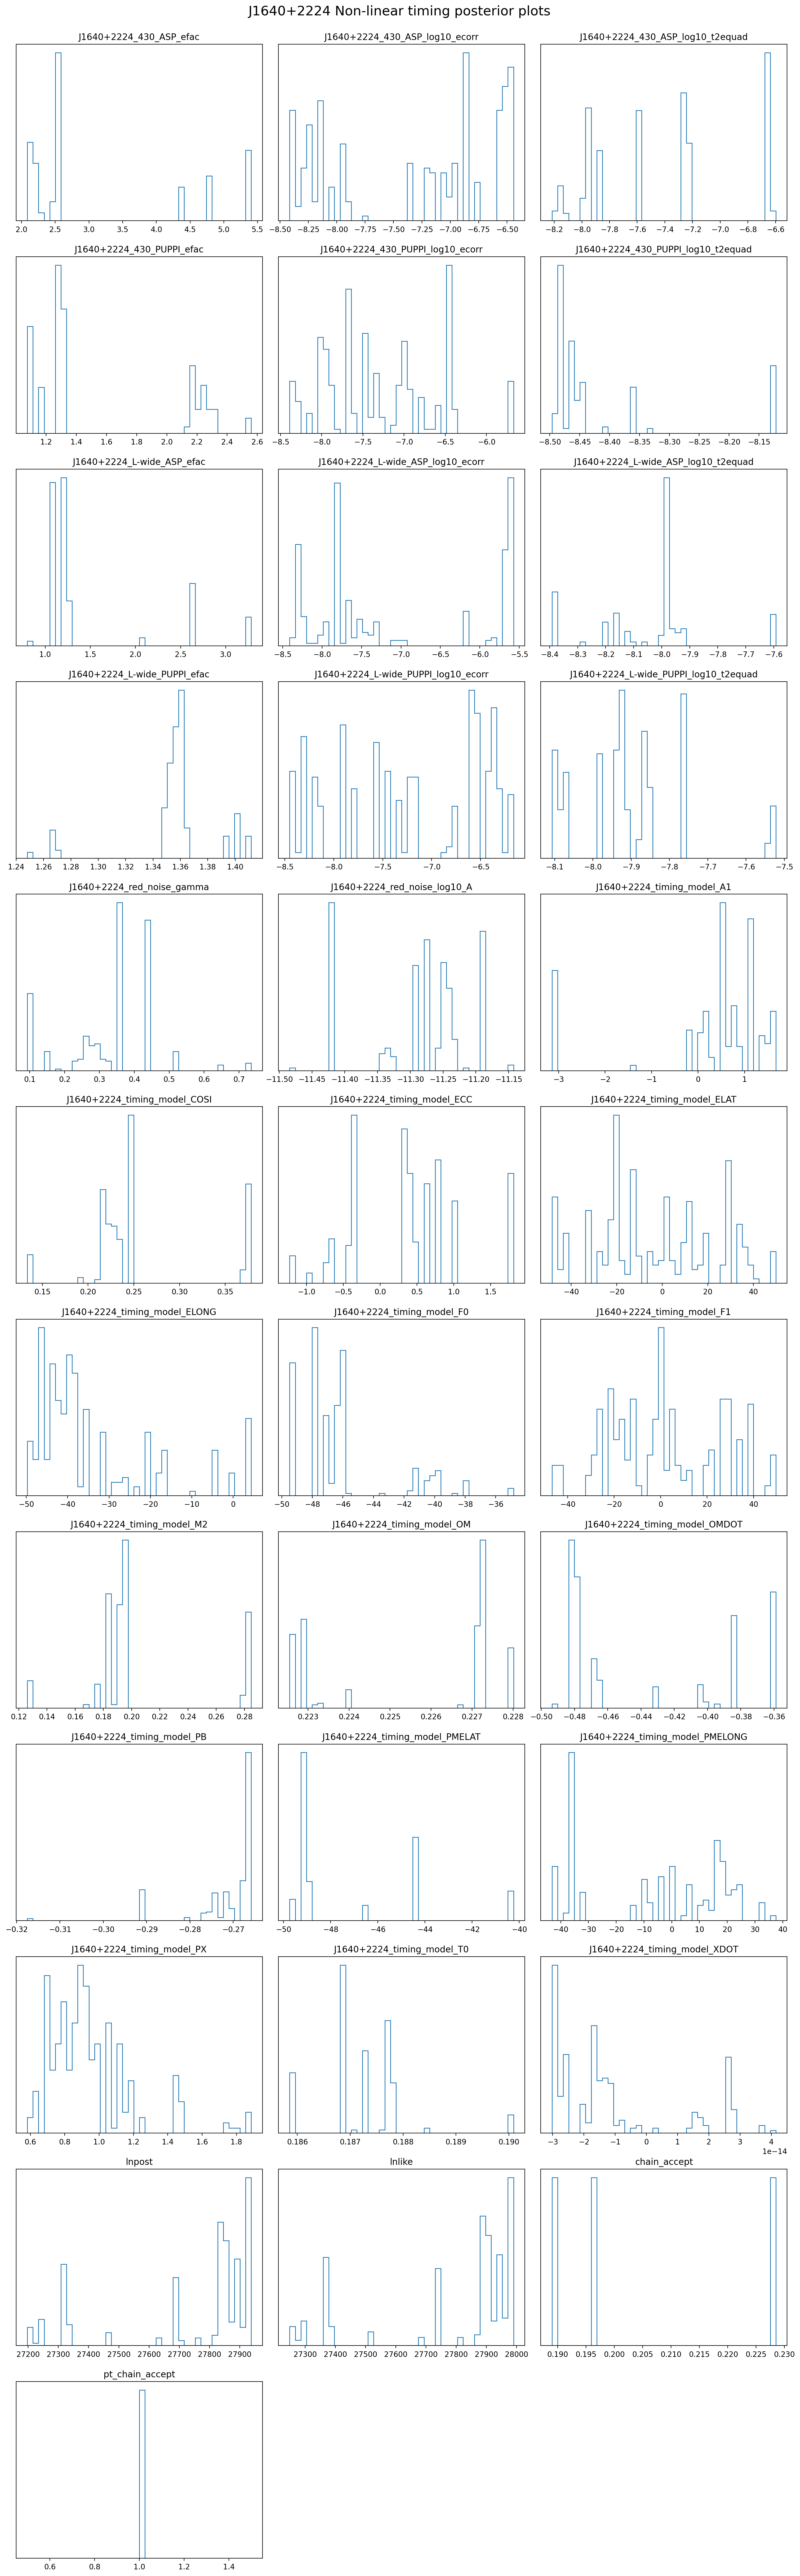

In [17]:
dg.plot_chains(core_anm_nltm,
               suptitle="J1640+2224 Non-linear timing posterior plots",
               real_tm_pars=False)

### Corner Plots

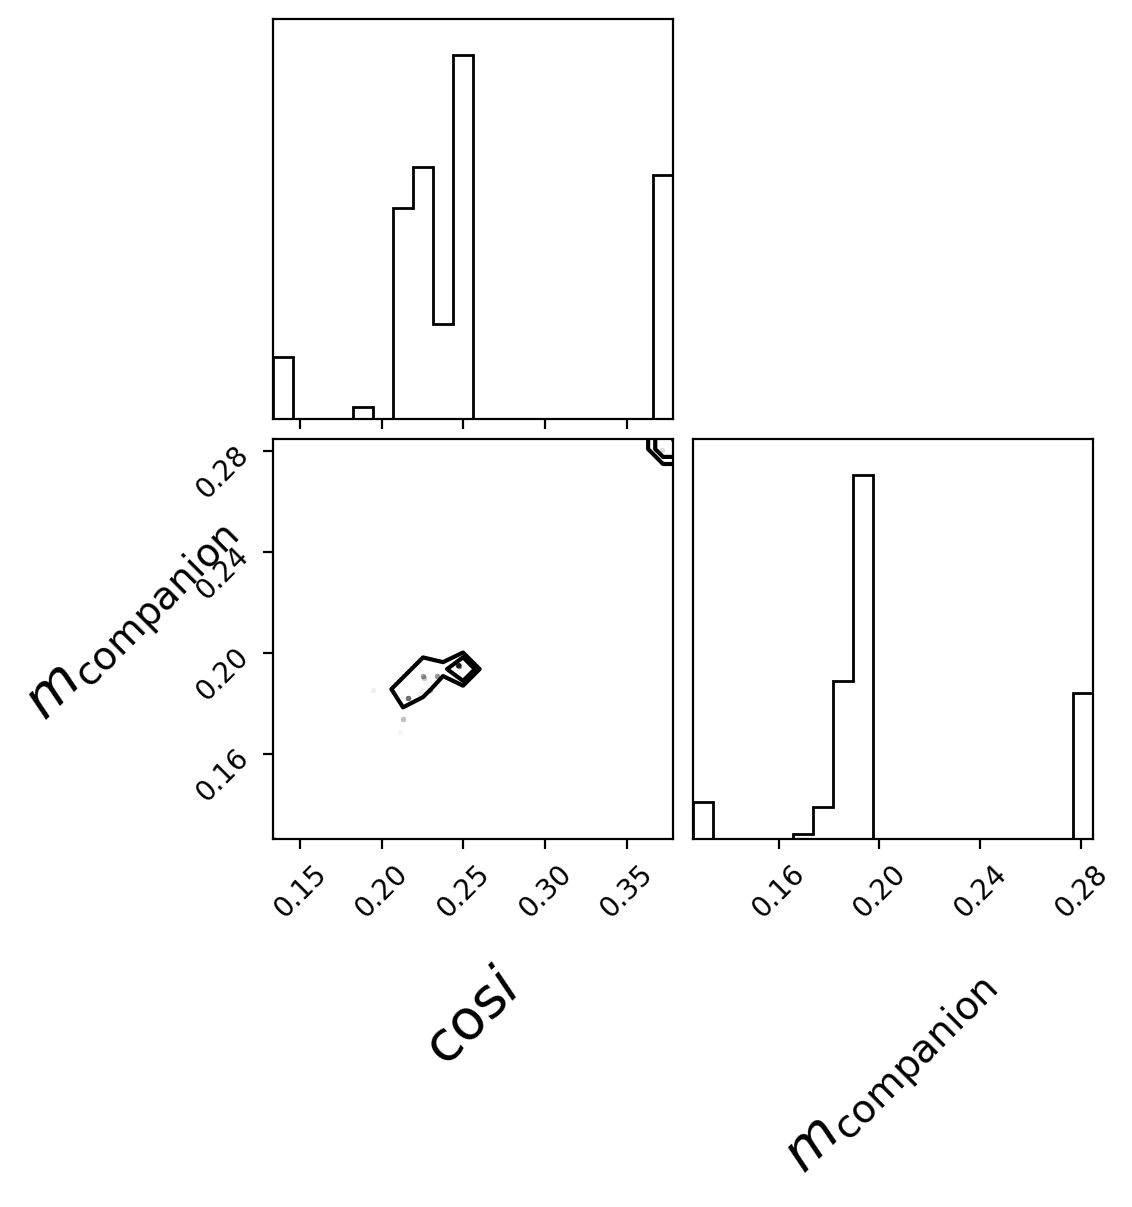

In [18]:
plt_param = core_anm_nltm.get_param(['J1640+2224_timing_model_COSI','J1640+2224_timing_model_M2'],
                                    tm_convert=True)
hist2d_kwargs = {
        "plot_density": False,
        "no_fill_contours": True,
        "data_kwargs": {"alpha": 0.02},
    }
ranges = np.ones(len(plt_param)) * 0.98
fig = corner.corner(
        plt_param,
        ranges=ranges,
        labels=[r'$\mathrm{cos}i$',r'$m_{\mathrm{companion}}$'],
        levels=[0.68, 0.95],
        label_kwargs={"fontsize": 20, "rotation": 45},
        **hist2d_kwargs,
    )